**1. Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

**2. Loading the Dataset**

In [2]:
ab = pd.read_csv("ab_data.csv")
countries = pd.read_csv("countries.csv")

**3. Understanding the Dataset Structure**

In [4]:
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [6]:
ab.shape

(294480, 5)

In [7]:
ab.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [8]:
ab.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


**Step 4: Clean Incorrect Rows**

In [9]:
ab[
    ((ab['group'] == 'control') & (ab['landing_page'] != 'old_page')) |
    ((ab['group'] == 'treatment') & (ab['landing_page'] != 'new_page'))
]

,user_id,timestamp,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
...,...,...,...,...,...
294014,813406,25:33.2,treatment,old_page,0
294200,928506,32:10.5,control,new_page,0
294252,892498,11:10.5,treatment,old_page,0
294253,886135,49:20.5,control,new_page,0


Important rule of A/B testing:
Control group → must see old_page
Treatment group → must see new_page

**Removing incorrect rows**

In [11]:
ab_clean = ab.drop(
    ab[
        ((ab['group'] == 'control') & (ab['landing_page'] != 'old_page')) |
        ((ab['group'] == 'treatment') & (ab['landing_page'] != 'new_page'))
    ].index
)

**Verifying cleaned data**

In [12]:
ab_clean['group'].value_counts()

,count
group,
treatment,145313
control,145274


**Step 5: Separate Control and Treatment Groups**

In [13]:
control = ab_clean[ab_clean['group'] == 'control']
treatment = ab_clean[ab_clean['group'] == 'treatment']

**Step 6: Define Hypotheses and Significance Level**

In [14]:
alpha = 0.05

**Step 7: Calculate Conversion Rates**


In [15]:
control_rate = control['converted'].mean()
treatment_rate = treatment['converted'].mean()
control_rate, treatment_rate

(np.float64(0.1203863045004612), np.float64(0.11880561271187023))

**Step 8: Perform the T-Test**

In [16]:
t_stat, p_value = stats.ttest_ind(
    control['converted'],
    treatment['converted']
)
p_value

np.float64(0.18919289246960475)

**Step 9: Interpret the P-Value**

In [17]:
if p_value < alpha:
    print("Reject H0 → Significant difference")
else:
    print("Fail to Reject H0 → No significant difference")

Fail to Reject H0 → No significant difference


**Step 10: Calculate Confidence Interval**

In [18]:
diff = treatment_rate - control_rate
se = np.sqrt(
    (control['converted'].var()/len(control)) +
    (treatment['converted'].var()/len(treatment))
)
ci_low = diff - 1.96 * se
ci_high = diff + 1.96 * se
ci_low, ci_high

(np.float64(-0.003940341944692083), np.float64(0.0007789583675101527))

**Step 11: Visualize Conversion Rates**

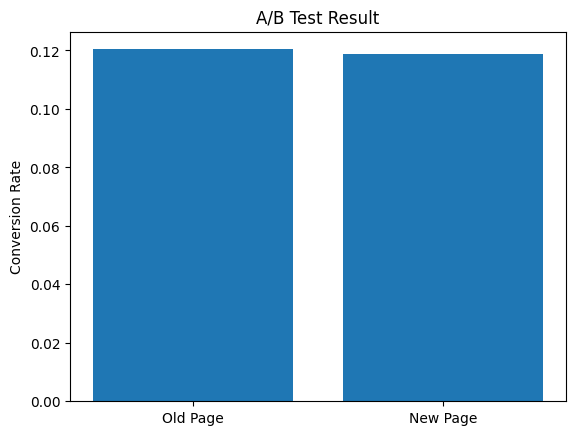

In [19]:
plt.bar(['Old Page', 'New Page'], [control_rate, treatment_rate])
plt.ylabel("Conversion Rate")
plt.title("A/B Test Result")
plt.show()

**Step 12: Merge Country Data**

In [20]:
full_data = ab_clean.merge(countries, on='user_id')
full_data.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [24]:
summary = pd.DataFrame({
    "Metric": [
        "Control Conversion Rate",
        "Treatment Conversion Rate",
        "Conversion Difference",
        "P-value",
        "CI Lower Bound",
        "CI Upper Bound",
        "Result"
    ],
    "Value": [
        control_rate,
        treatment_rate,
        treatment_rate - control_rate,
        p_value,
        ci_low,
        ci_high,
        "Not Significant"
    ]
})

summary


,Metric,Value
0,Control Conversion Rate,0.120386
1,Treatment Conversion Rate,0.118806
2,Conversion Difference,-0.001581
3,P-value,0.189193
4,CI Lower Bound,-0.00394
5,CI Upper Bound,0.000779
6,Result,Not Significant


In [25]:
summary.to_csv("ab_test_summary.csv", index=False)

**Final Conclusion and Business Recommendation**

Based on the statistical analysis, the conversion rates of the old and new landing pages are compared.
Since the p-value is greater than the significance level, the null hypothesis is not rejected.
This indicates that the new landing page does not result in a statistically significant improvement in conversions.
Therefore, it is recommended not to deploy the new page at this time.